***Project 2: Spotify Marketing***

**Step 1: Import Data and Settings to start the project**

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


plt.style.use('default')
sns.set_theme()


***Step 2: Business Understanding***

**Scenario**

The project is beneficial to optimize efficient marketing campaign in the Music industry. Music labels and digital marketers make decisions to decide which tracks deserve marketing investments. If a company or a sole business person decides to investment they'll need reassurance of financial gain and not financial loss to maximize profit. 

**Goal:**

Analyzing the dataset to get a predictive model for track popularity. Since the more popular a track is the potential chance that music labels and digital marketers can get financial gain with utilizing this model. A reminder that this does cover data from 2009-2025 and by the time the predictive model is made the data would be questioned to change. Must update data in correspondense to the timeframe desired for analysis.

In [61]:
# Load the cleaned Spotify data
df = pd.read_csv('spotify_data clean.csv')

# Display the first few rows of the dataframe
df.head()
df.describe()

,track_number,track_popularity,artist_popularity,artist_followers,album_total_tracks,track_duration_min
count,8582.000000,8582.000000,8582.000000,8.582000e+03,8582.000000,8582.000000
mean,5.772547,52.356211,69.730016,2.403472e+07,13.789443,3.492805
std,6.052792,23.816076,19.645979,3.803180e+07,11.887131,1.057970
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.070000
25%,1.000000,39.000000,60.000000,4.623200e+05,6.000000,2.880000
50%,4.000000,58.000000,74.000000,6.105547e+06,13.000000,3.445000
75%,9.000000,71.000000,84.000000,2.725255e+07,17.000000,3.990000
max,102.000000,99.000000,100.000000,1.455421e+08,181.000000,13.510000


****Variable Information:****

**track number: The sequence postion within its album**

**track_popularity: The real-time engagement (streams, saves, shares, etc.)**

**artist_popularity: Reflection of an artist music being recently played**

**artist_followers: The amount of users who click the follow button on an artist's profile**

**album_total_tracks: The total amount of songs within a specific album**

**track_duration_min: Duration of track (imported data from kaggle is converted)**



In [5]:
# Convert dates
df["album_release_date"] = pd.to_datetime(df["album_release_date"], errors="coerce")
df = df[df["album_release_date"].dt.year.between(2009, 2025)]
df["release_year"] = df["album_release_date"].dt.year

# Extract primary genre
df["primary_genre"] = (
    df["artist_genres"]
    .fillna("Unknown")
    .astype(str)
    .str.split(",")
    .str[0]
    .str.strip()
)

df["explicit"] = df["explicit"].astype(bool)

df.shape

(7188, 17)

Track popularity

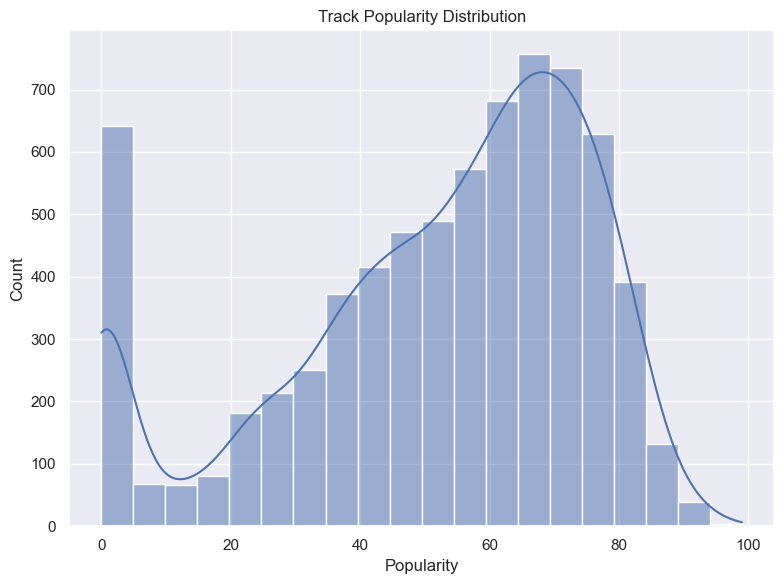

In [14]:
# More Detailed plot with labels
plt.figure(figsize=(8,6), dpi=100)
sns.histplot(df["track_popularity"], bins=20, kde=True)
plt.title("Track Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Track popularity over time

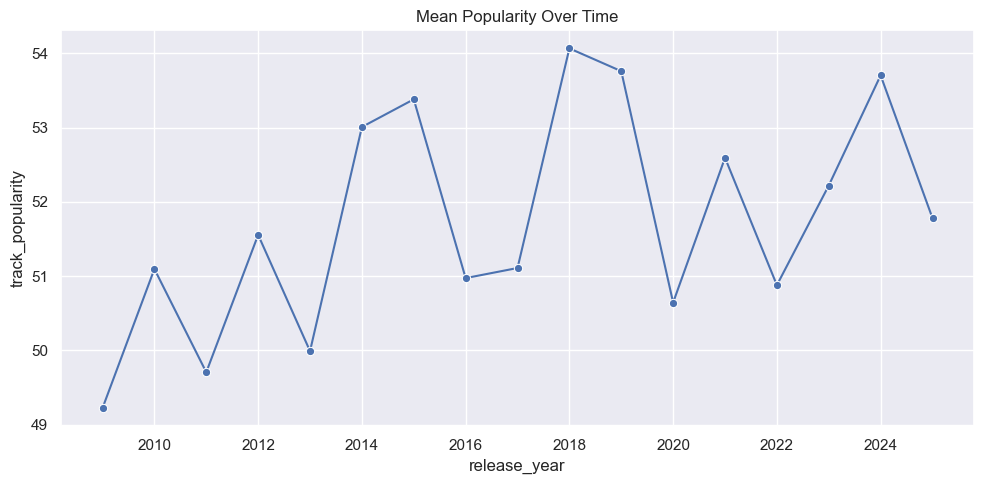

In [17]:
pop_by_year = df.groupby("release_year")["track_popularity"].mean().reset_index()
plt.figure(figsize=(10,5), dpi=100)
sns.lineplot(data=pop_by_year, x="release_year", y="track_popularity", marker="o")
plt.title("Mean Popularity Over Time")
plt.tight_layout()
plt.show()

Artist popularity vs Track Popularity


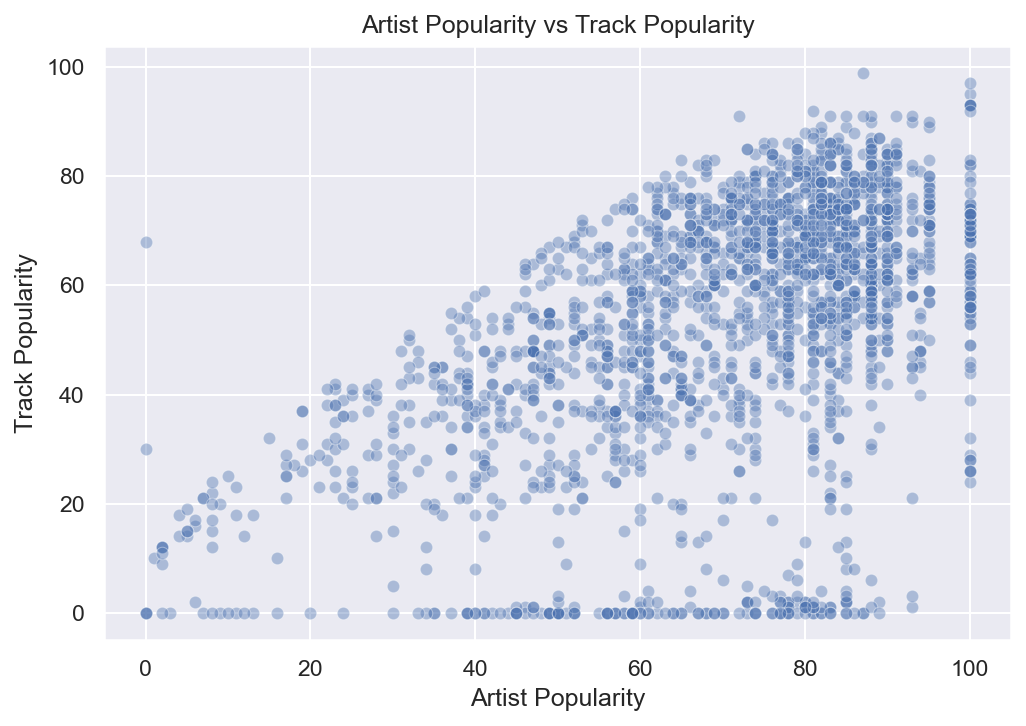

,track_popularity,artist_popularity,artist_followers
track_popularity,1.000000,0.496036,0.258695
artist_popularity,0.496036,1.000000,0.648054
artist_followers,0.258695,0.648054,1.000000


In [20]:
plt.figure(figsize=(7,5), dpi=150)
sns.scatterplot(
    data=df.sample(min(2000, len(df)), random_state=42),
    x="artist_popularity",
    y="track_popularity",
    alpha=0.4,
)
plt.title("Artist Popularity vs Track Popularity")
plt.xlabel("Artist Popularity")
plt.ylabel("Track Popularity")
plt.tight_layout()
plt.show()

df[["track_popularity", "artist_popularity", "artist_followers"]].corr()


Explicit vs Non-Explicit

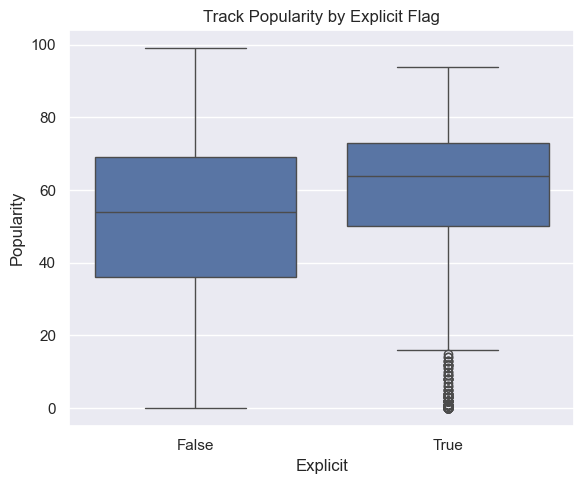

In [21]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="explicit", y="track_popularity")
plt.title("Track Popularity by Explicit Flag")
plt.xlabel("Explicit")
plt.ylabel("Popularity")
plt.tight_layout()
plt.show()


Genre Popularity

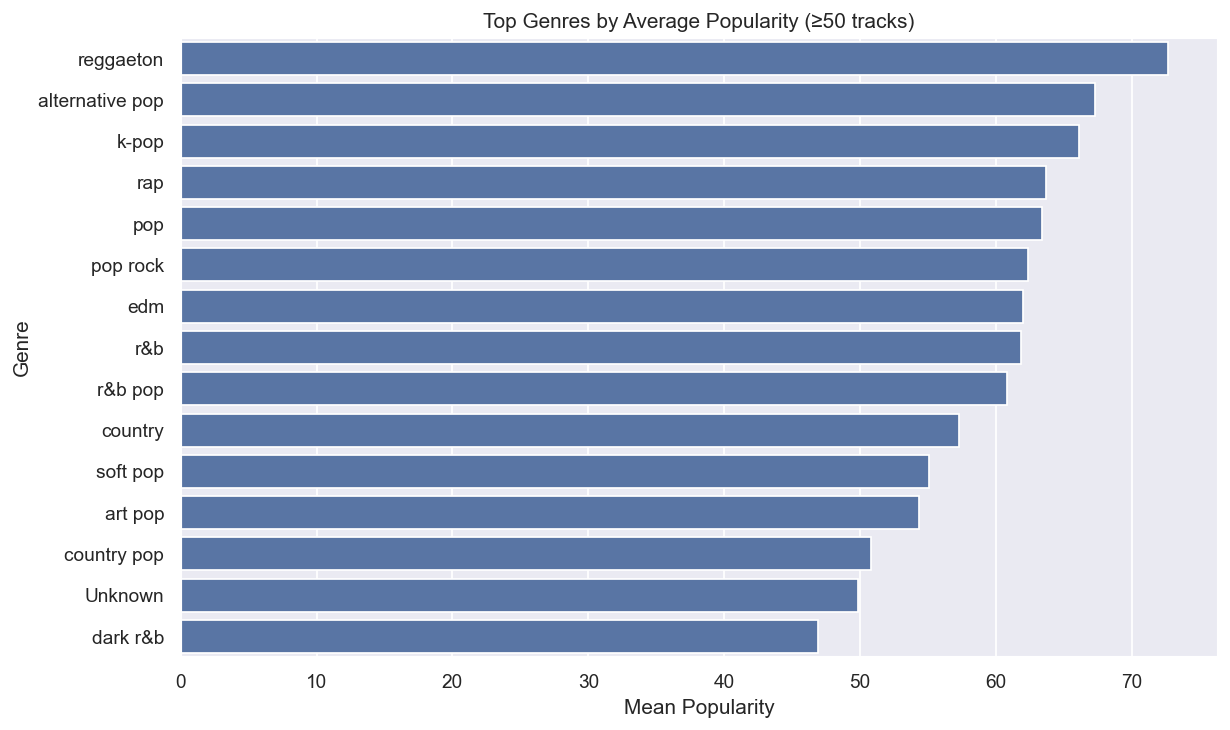

In [27]:
genre_stats = (
    df.groupby("primary_genre")["track_popularity"]
    .agg(["count", "mean"])
    .reset_index()
    .query("count >= 50")
    .sort_values("mean", ascending=False)
)

plt.figure(figsize=(10,6), dpi=125)
sns.barplot(data=genre_stats.head(15), x="mean", y="primary_genre")
plt.title("Top Genres by Average Popularity (≥50 tracks)")
plt.xlabel("Mean Popularity")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


***Part 3: Modeling***

In [45]:
# Machine Learning Model Preparation

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

import joblib


Clean and prepare Data:

    * Models needs correct datatime format, release year column, primary genre extraction, and to further polish the data utilize "bool" to clean and make it easier for the model

In [46]:
# Data Preprocessing

# Convert relase dates
df["album_release_date"] = pd.to_datetime(df["album_release_date"], errors="coerce")

# filter years 2009-2025
df = df[df["album_release_date"].dt.year.between(2009, 2025)]

# Extract release year
df["release_year"] = df["album_release_date"].dt.year

# Extract primary genre
df["primary_genre"] = (
    df["artist_genres"]
    .fillna("Unknown")
    .astype(str)
    .str.split(",")
    .str[0]
    .str.strip()
)

df["explicit"] = df["explicit"].astype(bool)

df.shape


(7188, 17)

In [47]:
class DateGenreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="album_release_date", genres_col="artist_genres"):
        self.date_col = date_col
        self.genres_col = genres_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

#Relase year extraction
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        X["release_year"] = X[self.date_col].dt.year

# Extract primary genre
        X["primary_genre"] = (
            X[self.genres_col]
            .fillna("Unknown")
            .astype(str)
            .str.split(",")
            .str[0]
            .str.strip()
        )
# Explicit conversion
        X["explicit"] = X["explicit"].astype(bool)

        return X


Define features

In [48]:
TARGET = "track_popularity"

feature_cols = [
    "track_number",
    "artist_popularity",
    "artist_followers",
    "album_total_tracks",
    "track_duration_min",
    "album_release_date",
    "artist_genres",
    "album_type",
    "explicit",
]

X = df[feature_cols]
y = df[TARGET]

# Train-test split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Creating preprocess transformers

In [49]:
numeric_features = [
    "track_number",
    "artist_popularity",
    "artist_followers",
    "album_total_tracks",
    "track_duration_min",
    "release_year",
]

categorical_features = [
    "primary_genre",
    "album_type",
    "explicit",
]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


Build baseline randomforest pipleine

I create a model using a Random Forest Regressor inside a scikit learn pipeline. The objective is to perform benchmark before attempting hyperparameter tuning.

In [50]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("features", DateGenreTransformer()),
    ("preprocess", preprocessor),
    ("model", model),
])


Training Baseline Model

In [ ]:
# Training the Baseline Model
pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)


In [52]:
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 18.89804328800601
R²: 0.38027633524564064


The RMSE of 18.8 suggest moderate prediction error on the popularity scale. While R^2 score of .38 indicates the model explains roughly 30% of the variance. (A need for improvements)

In [53]:
# GridSearchCV

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 3, 5],
}

In [54]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features', DateGenreTransformer()),
                                       ('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['track_number',
                                                                          'artist_popularity',
                                                                          'artist_followers',
                                                                          'album_total_tracks',
                                                                          'track_duration_min',
                                                                          'release_year']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['primary_genre',
                                                                          'album_type',
                                                                          'explicit'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 3, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

Evaluate Tuned Model

In [57]:
grid_preds = grid.predict(X_test)

grid_rmse = root_mean_squared_error(y_test, grid_preds)
grid_r2 = r2_score(y_test, grid_preds)

print("GridSearch RMSE:", grid_rmse)
print("GridSearch R²:", grid_r2)
print("Best Params:", grid.best_params_)

GridSearch RMSE: 18.64735146821291
GridSearch R²: 0.3966091576343659
Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}


Saving the  Model

In [58]:
import os
import joblib

os.makedirs("../models", exist_ok=True)

best_model_path = "../models/spotify_popularity_pipeline_tuned.pkl"
joblib.dump(grid.best_estimator_, best_model_path)

print("Saved tuned model to:", best_model_path)


Saved tuned model to: ../models/spotify_popularity_pipeline_tuned.pkl
